# Подготовка данных


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [41]:
#загрузим тренировочный набор данных CIFAR-10 и применим преобразование в тензор и нормализацию:
transform = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform1 = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform1)
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [43]:
# обучающая и тестовая выборки:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")

Размер обучающей выборки: 50000
Размер тестовой выборки: 10000


# Создание нейросети

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Первый сверточный слой: вход 3 канала (цветное изображение), 16 фильтров, размер ядра 3x3:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Второй сверточный слой: 16 входных каналов, 32 фильтра, ядро 3x3:
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Третий сверточный слой:
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Полносвязный слой для классификации
        # Размер входа учитывает уменьшение spatial size с 32x32 до 4x4 после 3 max pooling (каждый уменьшает в 2 раза)
        self.fc = nn.Linear(64 * 4 * 4, num_classes)

        # MaxPooling слой для уменьшения размерности
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  #
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # выпрямляем перед полносвязным слоем

        x = self.fc(x)
        return x


model = SimpleCNN(num_classes=10)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Обучение и тестирование модели


In [24]:
num_epochs = 10  # Количество эпох обучения

for epoch in range(num_epochs):
    model.train()  # Режим обучения, рассчет и минимизация потерь
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Обнуляем градиенты

        outputs = model(inputs)  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисляем потерю
        loss.backward()  # Обратный проход
        optimizer.step()  # Обновляем веса

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Оценка на тестовой выборке
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test accuracy after epoch {epoch+1}: {accuracy:.2f}%")

print("Обучение завершено.")

Epoch 1/10, Loss: 1.2847
Test accuracy after epoch 1: 61.76%
Epoch 2/10, Loss: 0.9735
Test accuracy after epoch 2: 65.61%
Epoch 3/10, Loss: 0.8653
Test accuracy after epoch 3: 68.45%
Epoch 4/10, Loss: 0.8003
Test accuracy after epoch 4: 69.49%
Epoch 5/10, Loss: 0.7551
Test accuracy after epoch 5: 72.09%
Epoch 6/10, Loss: 0.7145
Test accuracy after epoch 6: 71.94%
Epoch 7/10, Loss: 0.6859
Test accuracy after epoch 7: 74.03%
Epoch 8/10, Loss: 0.6587
Test accuracy after epoch 8: 72.37%
Epoch 9/10, Loss: 0.6386
Test accuracy after epoch 9: 74.77%
Epoch 10/10, Loss: 0.6198
Test accuracy after epoch 10: 75.20%
Обучение завершено.


# Улучшение архитектуры нейросети


In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.leaky_relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.leaky_relu(out)
        return out


class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.resblock1 = ResidualBlock(32)
        self.resblock2 = ResidualBlock(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.resblock3 = ResidualBlock(64)

        self.dropout = nn.Dropout(0.3)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.resblock1(x)
        x = self.resblock2(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.resblock3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Обучение и тестирование улучшенной модели

Epoch 1/20 — Потеря: 1.5182 — Точность на тесте: 44.88%
Epoch 2/20 — Потеря: 1.1641 — Точность на тесте: 60.92%
Epoch 3/20 — Потеря: 1.0336 — Точность на тесте: 62.22%
Epoch 4/20 — Потеря: 0.9451 — Точность на тесте: 63.56%
Epoch 5/20 — Потеря: 0.8747 — Точность на тесте: 64.59%
Epoch 6/20 — Потеря: 0.8129 — Точность на тесте: 64.30%
Epoch 7/20 — Потеря: 0.7610 — Точность на тесте: 71.82%
Достигнута требуемая точность 71.82%, обучение остановлено.


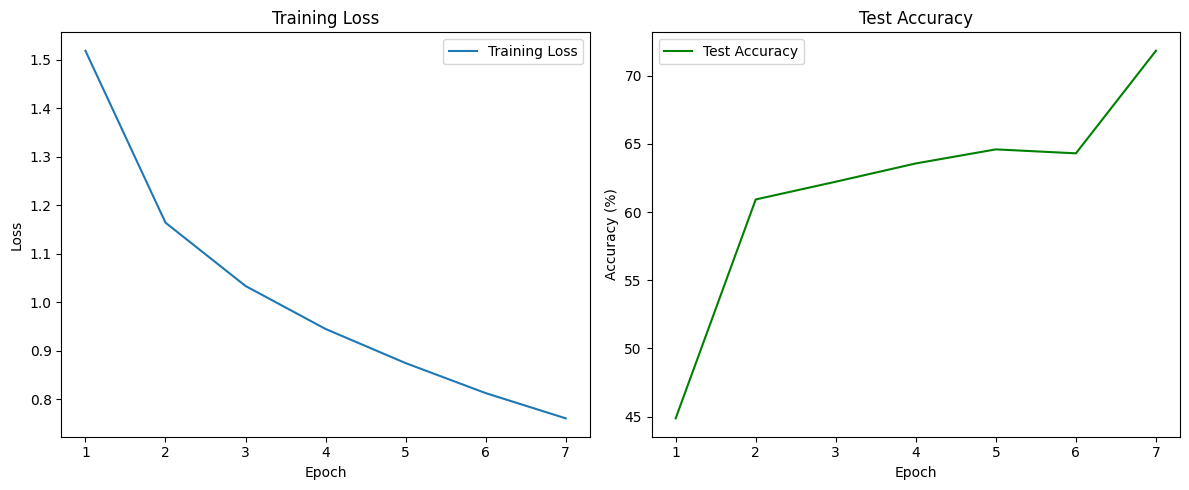

In [38]:
# Аугментация и нормализация для обучающей выборки
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),    # Случайное обрезание с паддингом для увеличения разнообразия данных
    transforms.RandomHorizontalFlip(),       # Случайное горизонтальное отражение (с вероятностью 0.5)
    transforms.ToTensor(),                    # Преобразование изображений в тензоры
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # Среднее по каналам CIFAR-10
                         (0.2023, 0.1994, 0.2010))  # Стандартное отклонение по каналам
])

# Только нормализация для тестовой выборки (без аугментаций)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Загрузка данных с применением трансформаций
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                          shuffle=False, num_workers=2)



model = ImprovedCNN(num_classes=10).to(device)

# Функция потерь (кросс-энтропия подходит для многоклассовой классификации)
criterion = nn.CrossEntropyLoss()

# Оптимизатор Adam для настройки параметров сети
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Параметры обучения
train_losses = []
test_accuracies = []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # <-- добавляем сюда

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)  # <-- и сюда

    print(f"Epoch {epoch+1}/{num_epochs} — Потеря: {epoch_loss:.4f} — Точность на тесте: {accuracy:.2f}%")

    if accuracy >= 70.0:
        print(f"Достигнута требуемая точность {accuracy:.2f}%, обучение остановлено.")
        break


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()